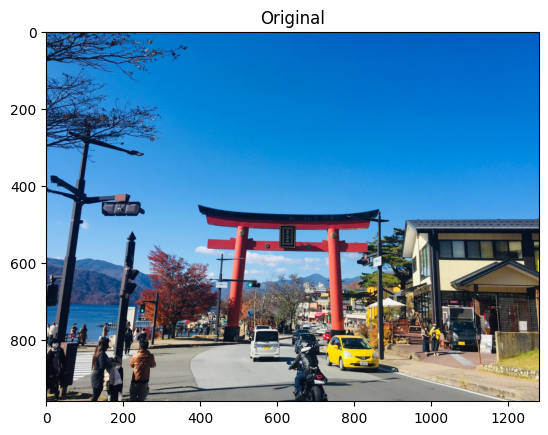

<ipython-input-10-cfa11e641431>:32: RuntimeWarning: overflow encountered in ubyte_scalars
  h_value = 60 * (((src[y, x, 0] - src[y, x, 1]) / delta) + 4)
<ipython-input-10-cfa11e641431>:28: RuntimeWarning: overflow encountered in ubyte_scalars
  h_value = 60 * (((src[y, x, 1] - src[y, x, 2]) / delta) % 6)
<ipython-input-10-cfa11e641431>:30: RuntimeWarning: overflow encountered in ubyte_scalars
  h_value = 60 * (((src[y, x, 2] - src[y, x, 0]) / delta) + 2)


(960, 1280, 3)
Window size:5. Time processing on CPU without shared memory: 433.63515996932983s


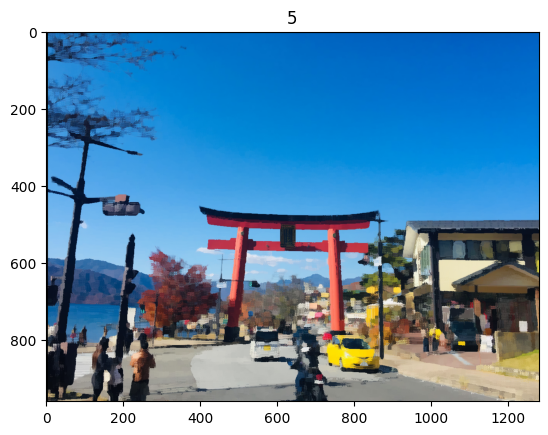

(960, 1280, 3)
Window size:6. Time processing on CPU without shared memory: 571.8690097332001s


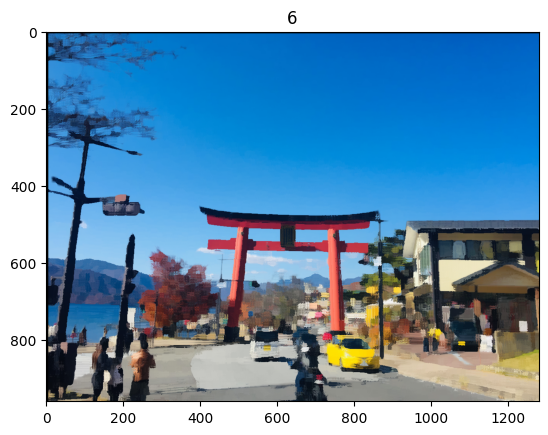

(960, 1280, 3)
Window size:7. Time processing on CPU without shared memory: 735.6915984153748s


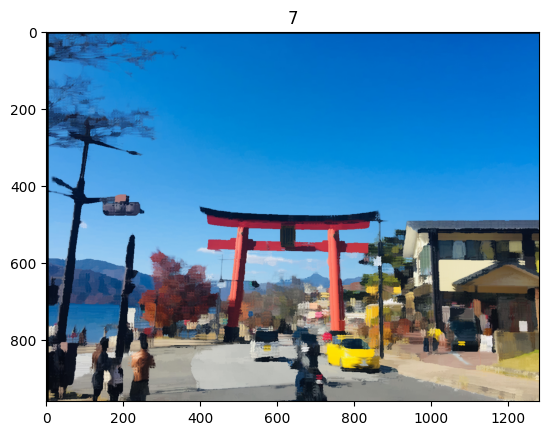

(960, 1280, 3)
Window size:8. Time processing on CPU without shared memory: 918.359828710556s


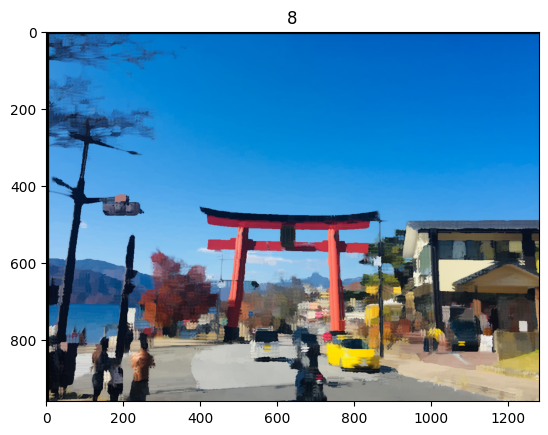

In [ ]:
import numba
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, types
from numba import jit
from matplotlib.image import imread
import math
import time
import cv2

# Load an image from a file
image_path = 'kuwahara.jpg'
image = imread(image_path)
plt.imshow(image), plt.title('Original')
plt.show()


def rgb_to_hsv(src):
    dst = src.copy()
    for x in range(0, src.shape[1]):
      for y in range(0, src.shape[0]):
        max_value = max(src[y, x, 0], src[y, x, 1], src[y, x, 2])
        min_value = min(src[y, x, 0], src[y, x, 1], src[y, x, 2])
        delta = max_value - min_value
        if delta == 0:
            h_value = 0
        elif max_value == src[y, x, 0]:
            h_value = 60 * (((src[y, x, 1] - src[y, x, 2]) / delta) % 6)
        elif max_value == src[y, x, 1]:
            h_value = 60 * (((src[y, x, 2] - src[y, x, 0]) / delta) + 2)
        elif max_value == src[y, x, 2]:
            h_value = 60 * (((src[y, x, 0] - src[y, x, 1]) / delta) + 4)

        if max_value == 0:
            s_value = 0
        else:
            s_value = delta / max_value
        v_value = max_value
        dst[y, x, 0] = h_value
        dst[y, x, 1] = s_value
        dst[y, x, 2] = v_value

    return dst


def kuwahara_filter_without_shared(input_image, window_size, hsv):
    output_image = input_image.copy()
    print(input_image.shape)
    for x in range(0,input_image.shape[0]):
      for y in range(0,input_image.shape[1]):
        mean_variances = np.zeros((4,9))
        for q in range(4):
            # Define the region for the current quadrant
            x_start, x_end, y_start, y_end = 0, 0, 0, 0

            if q == 0:
                x_start, x_end, y_start, y_end = x, x + window_size, y, y + window_size
            elif q == 1:
                x_start, x_end, y_start, y_end = x, x + window_size, y - window_size, y
            elif q == 2:
                x_start, x_end, y_start, y_end = x - window_size, x, y, y + window_size
            else:
                x_start, x_end, y_start, y_end = x - window_size, x, y - window_size, y

            # Extract the neighborhood for the current quadrant
            neighborhood_rgb = input_image[x_start:x_end, y_start:y_end, :]
            neighborhood = hsv[x_start:x_end, y_start:y_end, :]

            # Calculate the mean and variance for each channel
            for c in range(0,3):
                channel_values = neighborhood[:, :, c]
                channel_values_rgb = neighborhood_rgb[:, :, c]
                mean = 0.0
                mean_rgb = 0.0
                variance = 0.0
                size = neighborhood.shape[0]*neighborhood.shape[1]

                if size == 0:
                  break

                # Calculate the mean
                for i in range(neighborhood.shape[0]):
                    for j in range(neighborhood.shape[1]):
                        mean += channel_values[i, j]

                mean //= size


                for i in range(neighborhood_rgb.shape[0]):
                    for j in range(neighborhood_rgb.shape[1]):
                        mean_rgb += channel_values_rgb[i, j]

                mean_rgb //= size


                # Calculate the variance
                for i in range(neighborhood.shape[0]):
                    for j in range(neighborhood.shape[1]):
                        variance += (channel_values[i, j] - mean) ** 2

                variance /= size
                mean_variances[q, c] = variance
                mean_variances[q, c +3] = mean
                mean_variances[q, c +6] = mean_rgb

        # Determine the quadrant with the minimum variance
        min_variance_quadrant = 0
        min_variance =math.sqrt( mean_variances[0, 0] + mean_variances[0, 1] + mean_variances[0, 2])

        for q in range(1, 4):
            nn =math.sqrt( mean_variances[q, 0] + mean_variances[q, 1] + mean_variances[q, 2])
            if nn < min_variance:
                min_variance_quadrant = q
                min_variance = nn

        # Set the pixel value to the mean of the channel in the minimum variance quadrant
        output_image[x, y, 0] = mean_variances[min_variance_quadrant, 6]
        output_image[x, y, 1] = mean_variances[min_variance_quadrant, 7]
        output_image[x, y, 2] = mean_variances[min_variance_quadrant, 8]

    return output_image


# Implement with GPU
blockSizes = [(2,2),(4,4),(8, 8)]
times_gpu = []
size_test = [5,6,7,8]
window_size = 5
image_height, image_width, _ = image.shape

hsv = rgb_to_hsv(image)

for window_size in size_test:

  # Without shared memory
    start_time_gpu = time.time()
    result = kuwahara_filter_without_shared(image, window_size, hsv)
    time_gpu = time.time() - start_time_gpu
    times_gpu.append(time_gpu)
    print(f"Window size:{window_size}. Time processing on CPU without shared memory: {time_gpu}s")
    kuwahara_filter_image = np.array(result)
    plt.imsave(f'kuwahara_windowsize_{window_size}__without_sm.jpg', kuwahara_filter_image, cmap='gray')

    plt.title(window_size)
    plt.imshow(kuwahara_filter_image)
    plt.show()

